# Lesson 3. Homework.

#### Studied and practiced topics:
- Pytorch Dataset/Dataloader objects;
- Batchsize, Dropout layers;
- Optimizers (AdaGrad, RMSProp, Adam).

Use the `from sklearn.datasets import fetch_california_housing` dataset.

#### Your tasks are:
1. To create a Dataset object for loading the data.
2. To wrap the Dataset into the Dataloader object.
3. To write a neural network that will predict the real estate cost. The network has to include the BatchNorm and Dropout layers (in case you don't add these layers - argument your decision).
4. Compare the convergence of Adam, RMSProp and SGD, write down your conclusions.

#### Requirements:  
Do the `train_test_split` with the sklearn library and the following arguments - `random_state=13`, `test_size = 0.25`

In [235]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(95)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()

from tqdm import tqdm

In [3]:
dataset = fetch_california_housing(return_X_y=False, as_frame=True)
print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

### Quick Data Exploration 

In [4]:
df = dataset.frame
df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Nice that there aren't any null values!

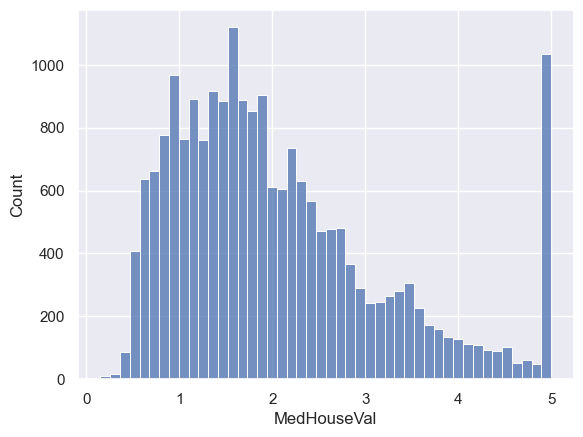

In [5]:
sns.histplot(df['MedHouseVal'])
plt.show()

It seems that the target feature is already normalized in a particular way, so that there are no bigger values than 5. 

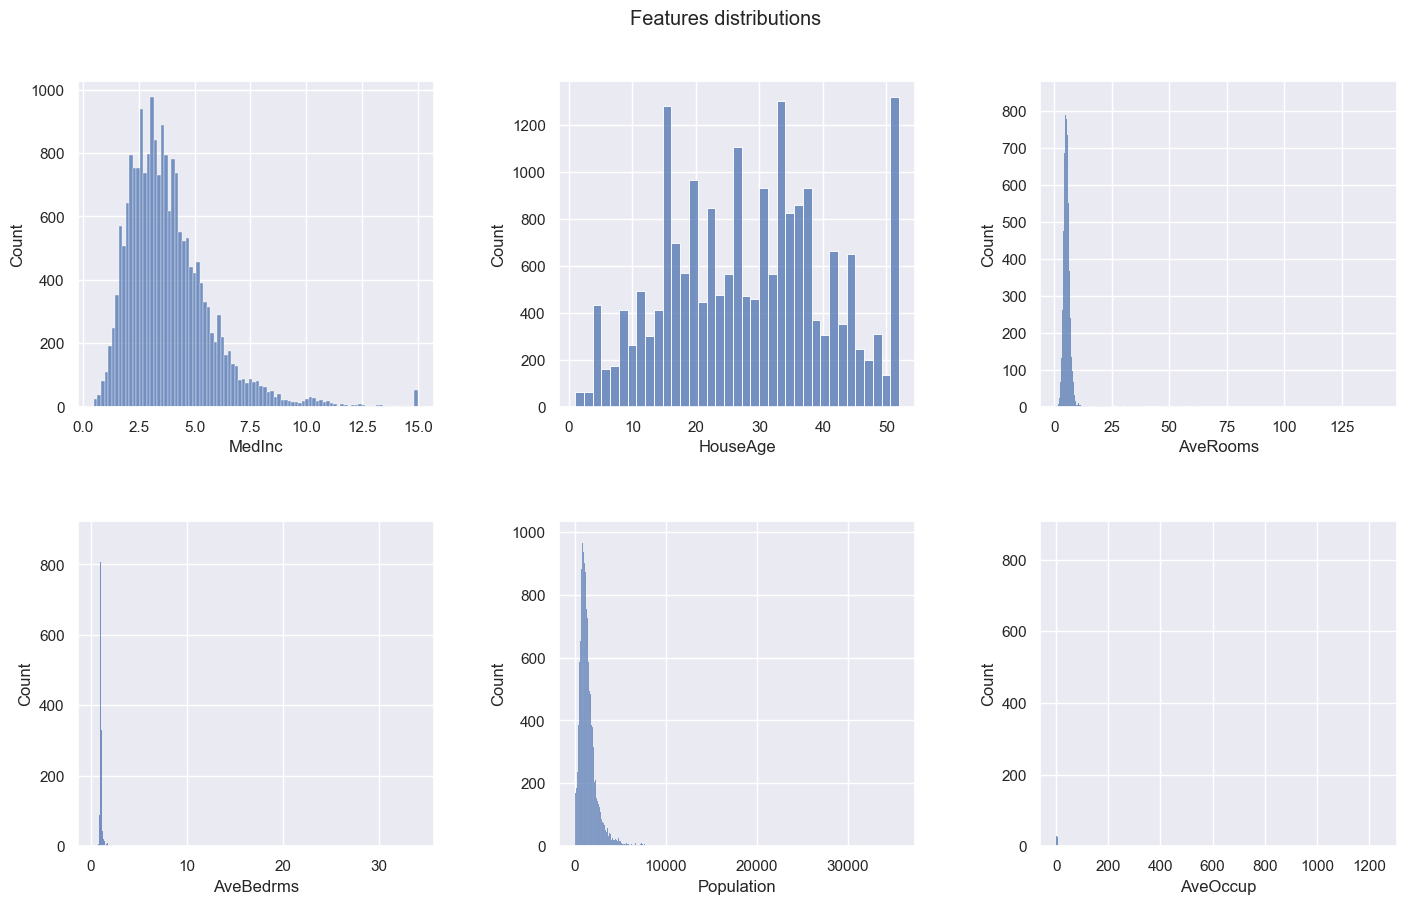

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
fig.tight_layout()
fig.suptitle('Features distributions')
plt.subplots_adjust(wspace=0.35, hspace=0.35, top=0.9)

sns.histplot(data=df.iloc[:, 0], ax=axes[0, 0])
sns.histplot(data=df.iloc[:, 1], ax=axes[0, 1])
sns.histplot(data=df.iloc[:, 2], ax=axes[0, 2])
sns.histplot(data=df.iloc[:, 3], ax=axes[1, 0])
sns.histplot(data=df.iloc[:, 4], ax=axes[1, 1])
sns.histplot(data=df.iloc[:, 5], ax=axes[1, 2])

plt.show()

MedInc and HouseAge also seem to be normalized, because they have a certain bound on values 15 and 50 respectively.    
  
The other features aren't normalized and contain some kind of outliers, so I will fastly clear them.  
  
I will also drop the geolocation features, because their usage is more tricky and it's out of the homework's scope :)

In [8]:
df.iloc[:, :-1].describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [53]:
# Ideally, I would leave the data in the range of 3 sigmas (3 standard deviations).
# However, I would also want to drop no more than 1% of the data for each feature.
print(f'1% of the dataset is equal to: {len(df) * 0.01:.0f} entries')

1% of the dataset is equal to: 206 entries


In [57]:
print(f'Number of rows where the "AveRooms" is more than 10: {len(df.loc[df["AveRooms"] > 10])}')
print(f'Number of rows where the "AveRooms" is more than 15: {len(df.loc[df["AveRooms"] > 15])}')
print(f'Number of rows where the "AveRooms" is more than 20: {len(df.loc[df["AveRooms"] > 20])}')

Number of rows where the "AveRooms" is more than 10: 226
Number of rows where the "AveRooms" is more than 15: 109
Number of rows where the "AveRooms" is more than 20: 69


In [32]:
print(f'Number of rows where the "AveBedrms" is more than 2: {len(df.loc[df["AveBedrms"] > 2])}')
print(f'Number of rows where the "AveBedrms" is more than 3: {len(df.loc[df["AveBedrms"] > 3])}')
print(f'Number of rows where the "AveBedrms" is more than 4: {len(df.loc[df["AveBedrms"] > 4])}')

Number of rows where the "AveBedrms" is more than 2: 235
Number of rows where the "AveBedrms" is more than 3: 107
Number of rows where the "AveBedrms" is more than 4: 67


In [59]:
print(f'Number of rows where the "Population" is more than 6000: {len(df.loc[df["Population"] > 6000])}')
print(f'Number of rows where the "Population" is more than 7500: {len(df.loc[df["Population"] > 7500])}')
print(f'Number of rows where the "Population" is more than 10000: {len(df.loc[df["Population"] > 10000])}')

Number of rows where the "Population" is more than 6000: 192
Number of rows where the "Population" is more than 7500: 81
Number of rows where the "Population" is more than 10000: 23


In [47]:
print(f'Number of rows where the "AveOccup" is more than 5: {len(df.loc[df["AveOccup"] > 5])}')
print(f'Number of rows where the "AveOccup" is more than 6: {len(df.loc[df["AveOccup"] > 6])}')
print(f'Number of rows where the "AveOccup" is more than 7: {len(df.loc[df["AveOccup"] > 7])}')

Number of rows where the "AveOccup" is more than 5000: 345
Number of rows where the "AveOccup" is more than 7500: 114
Number of rows where the "AveOccup" is more than 10000: 70


In [60]:
df_clean = df.drop(columns=['Latitude', 'Longitude'])
df_clean = df_clean.loc[df_clean['AveRooms'] < 10]
df_clean = df_clean.loc[df_clean['AveBedrms'] < 2]
df_clean = df_clean.loc[df_clean['Population'] < 6000]
df_clean = df_clean.loc[df_clean['AveOccup'] < 6]
df_clean.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,MedHouseVal
count,20065.000000,20065.000000,20065.000000,20065.000000,20065.000000,20065.000000,20065.000000
mean,3.866938,28.930625,5.265632,1.062921,1370.537154,2.905730,2.074652
std,1.890316,12.487676,1.213186,0.110584,872.645182,0.718234,1.156021
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.750000,0.149990
25%,2.562500,19.000000,4.429936,1.004963,793.000000,2.430657,1.197000
50%,3.531300,29.000000,5.205742,1.047473,1166.000000,2.817664,1.808000
75%,4.742200,37.000000,6.004651,1.096447,1707.000000,3.276471,2.658000
max,15.000100,52.000000,9.979167,1.990323,5982.000000,5.995680,5.000010


Now the data seems much more reliable. Lets normalize it.

In [64]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_clean)
df_scaled = pd.DataFrame(data=df_scaled, columns=df_clean.columns)
df_scaled.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,MedHouseVal
count,20065.000000,20065.000000,20065.000000,20065.000000,20065.000000,20065.000000,20065.000000
mean,0.232206,0.547659,0.483902,0.440309,0.228723,0.410953,0.396836
std,0.130365,0.244856,0.132835,0.066738,0.145952,0.136919,0.238354
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142246,0.352941,0.392399,0.405331,0.132129,0.320389,0.215877
50%,0.209059,0.549020,0.477344,0.430986,0.194514,0.394165,0.341856
75%,0.292568,0.705882,0.564819,0.460542,0.284997,0.481629,0.517113
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Lovely! Now lets wrap everything in a Dataset and DataLoader objects.  
  
### Creating Dataset and DataLoader objects.

In [175]:
class CaliforniaHousingDataset(torch.utils.data.Dataset):
    def __init__(self, return_train: bool):
        """
        A straight-forward pipeline of class methods 
        to load, preprocess, normalize and split the data
        """
        self._load_data()
        self._preprocess_data()
        self._normalize_data()    
        self._train_test_split()
        
        if return_train:
            self.data = self.X_train.reset_index(drop=True)
            self.labels = self.y_train.reset_index(drop=True)
        else:
            self.data = self.X_test.reset_index(drop=True)
            self.labels = self.y_test.reset_index(drop=True)
        
        # print(self.data)
        # print(self.labels)
        
    def _load_data(self):
        dataset = fetch_california_housing(return_X_y=False, as_frame=True)
        self.df = dataset.frame
        
    def _preprocess_data(self):
        df_clean = self.df.drop(columns=['Latitude', 'Longitude'])
        df_clean = df_clean.loc[df_clean['AveRooms'] < 10]
        df_clean = df_clean.loc[df_clean['AveBedrms'] < 2]
        df_clean = df_clean.loc[df_clean['Population'] < 6000]
        df_clean = df_clean.loc[df_clean['AveOccup'] < 6]
        self.df = df_clean
        
    def _normalize_data(self):
        scaler = MinMaxScaler()
        df_scaled = scaler.fit_transform(self.df)
        df_scaled = pd.DataFrame(data=df_scaled, columns=df_clean.columns)
        self.df = df_scaled
        
    def _train_test_split(self):
        X = self.df.iloc[:, :-1]
        y = self.df.iloc[:, -1]
        self.X_train, self.X_test, self.y_train, self.y_test = \
            train_test_split(X, y, 
                             random_state=13, 
                             test_size=0.25)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return self.data.iloc[index, :].to_numpy(), self.labels[index]

In [176]:
df_train = CaliforniaHousingDataset(return_train=True)
df_test = CaliforniaHousingDataset(return_train=False)

In [177]:
len(df_train), len(df_test)

(15048, 5017)

In [178]:
df_train[10]

(array([0.11718459, 0.90196078, 0.42336655, 0.42801718, 0.08596755,
        0.38126608]),
 0.10763048399800415)

In [179]:
df_train_loader = torch.utils.data.DataLoader(df_train,
                                              batch_size=len(df_train)//10,
                                              shuffle=True)
df_test_loader = torch.utils.data.DataLoader(df_test,
                                              batch_size=len(df_test)//10)

### Building a model.

In [208]:
class Perceptron(nn.Module):
    """ 
    A basic perceptron. 
    A fully connected layer, which takes input, multiplies it by the weights matrix, 
    adds bias and uses an activation function.
    """
    def __init__(
        self, 
        input_dim: int, 
        output_dim: int, 
        bias: bool = True,
        activation: callable = torch.relu
    ):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.bias = bias
        self.activation_func = activation
        # Use the class method to initialize the weights.
        self.fc = self._init_weights(nn.Linear(input_dim, output_dim, bias=bias))        
        
    def _init_weights(self, layer):
        """
        I decided to initialize weights with the He (Kaiman's) algorithm here, 
        since we are using the ReLu activation function
        """
        layer.weight.data = nn.init.kaiming_uniform_(
            layer.weight.data, 
            nonlinearity=self.activation_func.__name__
        )
        return layer
        
    def forward(self, inputs):
        fc_out = self.fc(inputs)
        output = self.activation_func(fc_out)
        return output
        

class SimpleLinearModel(nn.Module):
    """
    A very simple model with 2 hidden layers.
    Each layer is a Perceptron with different number of units.
    """
    def __init__(self, input_shape, hidden_dim):
        super().__init__()
        self.fc1 = Perceptron(input_shape, hidden_dim * 2)
        self.fc2 = Perceptron(hidden_dim * 2, hidden_dim)
        self.fc3 = Perceptron(hidden_dim, 1)
        
    def forward(self, inputs):
        layer_1 = self.fc1.forward(inputs)
        layer_2 = self.fc2.forward(layer_1)
        layer_3 = self.fc3.forward(layer_2)
        return layer_3

In [209]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

### 1) Train and test a model with Adam optimizer and no BatchNorm or Dropout layers.

In [ ]:
hidden_layer_dim = 16
model = SimpleLinearModel(6, hidden_layer_dim)
model.train()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_history = {'train_loss': [], 'test_loss': []}
for epoch in range(num_epochs):  
    current_loss = 0.0
    for i, data in enumerate(df_train_loader):
        inputs, labels = data[0].float(), data[1].float()
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss
        
        model.eval()
        current_loss_test = 0.0
        for data in df_test_loader:
            test_inputs, test_labels = \
                data[0].float(), data[1].float()

            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs.flatten(), test_labels)

            current_loss_test += test_loss
        model.train()
                
        if i % 10 == 0:
            print(f'[Epoch {epoch + 1}, batch {i}] ' \
                  f'loss: {current_loss / (i + 1):.4f}; ' \
                  f'loss_test: {current_loss_test / 10:.4f}.')
            
        train_history['train_loss'].append(current_loss.item() / (i + 1))
        train_history['test_loss'].append(current_loss_test.item() / 10)

print('Training is finished!')

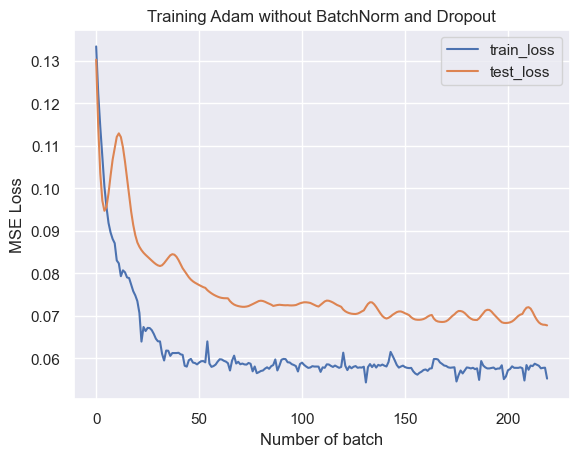

In [319]:
plt.plot(train_history['train_loss'], label='train_loss')
plt.plot(train_history['test_loss'], label='test_loss')
plt.title('Training Adam without BatchNorm and Dropout')
plt.xlabel('Number of batch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### 2) Train and test a model with SGD optimizer, BatchNorm, and Dropout layers.

In [293]:
class LinearBatchNormDropoutModel(nn.Module):
    """
    A  model with 2 hidden layers, 3 Batch Normalization layers and 2 Dropout layers.
    """
    def __init__(self, input_shape, hidden_dim):
        super().__init__()        
        self.bn1 = nn.BatchNorm1d(input_shape)
        self.fc1 = Perceptron(input_shape, hidden_dim * 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim * 2)
        self.dp2 = nn.Dropout(0.25)
        self.fc2 = Perceptron(hidden_dim * 2, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dp3 = nn.Dropout(0.25)
        self.fc3 = Perceptron(hidden_dim, 1)
        
    def forward(self, inputs):
        inputs_norm = self.bn1(inputs)
        layer_1 = self.fc1.forward(inputs_norm)
        l1_norm = self.bn2(layer_1)
        l1_dp = self.dp2(l1_norm)
        layer_2 = self.fc2.forward(l1_dp)
        l2_norm = self.bn3(layer_2)
        l2_dp = self.dp3(l2_norm)
        layer_3 = self.fc3.forward(l2_dp)
        return layer_3

In [ ]:
hidden_layer_dim = 16
model = LinearBatchNormDropoutModel(6, hidden_layer_dim)
model.train()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

num_epochs = 20
train_history_1 = {'train_loss': [], 'test_loss': []}
for epoch in range(num_epochs):  
    current_loss = 0.0
    for i, data in enumerate(df_train_loader):
        inputs, labels = data[0].float(), data[1].float()

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss

        model.eval()
        current_loss_test = 0.0
        for data in df_test_loader:
            test_inputs, test_labels = \
                data[0].float(), data[1].float()

            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs.flatten(), test_labels)

            current_loss_test += test_loss
        model.train()

        if i % 10 == 0:
            print(f'[Epoch {epoch + 1}, batch {i}] ' \
                  f'loss: {current_loss / (i + 1):.4f}; ' \
                  f'loss_test: {current_loss_test / 10:.4f}.')

        train_history_1['train_loss'].append(current_loss.item() / (i + 1))
        train_history_1['test_loss'].append(current_loss_test.item() / 10)

print('Training is finished!')

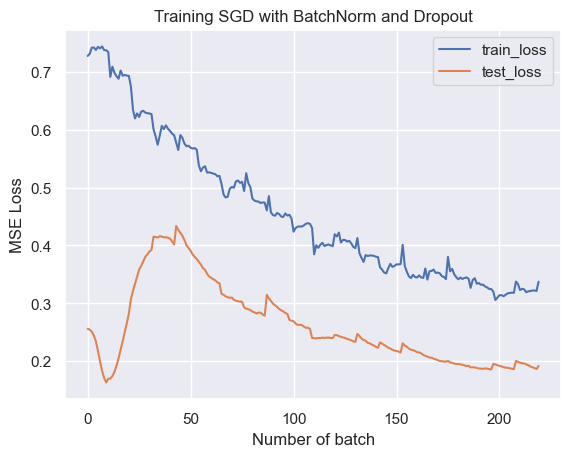

In [321]:
plt.plot(train_history_1['train_loss'], label='train_loss')
plt.plot(train_history_1['test_loss'], label='test_loss')
plt.title('Training SGD with BatchNorm and Dropout')
plt.xlabel('Number of batch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### 3) Train and test a model with RMSprop optimizer, BatchNorm, and Dropout layers.

In [ ]:
hidden_layer_dim = 16
model = LinearBatchNormDropoutModel(6, hidden_layer_dim)
model.train()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

num_epochs = 20
train_history_2 = {'train_loss': [], 'test_loss': []}
for epoch in range(num_epochs):  
    current_loss = 0.0
    for i, data in enumerate(df_train_loader):
        inputs, labels = data[0].float(), data[1].float()

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss

        model.eval()
        current_loss_test = 0.0
        for data in df_test_loader:
            test_inputs, test_labels = \
                data[0].float(), data[1].float()

            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs.flatten(), test_labels)

            current_loss_test += test_loss
        model.train()

        if i % 10 == 0:
            print(f'[Epoch {epoch + 1}, batch {i}] ' \
                  f'loss: {current_loss / (i + 1):.4f}; ' \
                  f'loss_test: {current_loss_test / 10:.4f}.')

        train_history_2['train_loss'].append(current_loss.item() / (i + 1))
        train_history_2['test_loss'].append(current_loss_test.item() / 10)

print('Training is finished!')

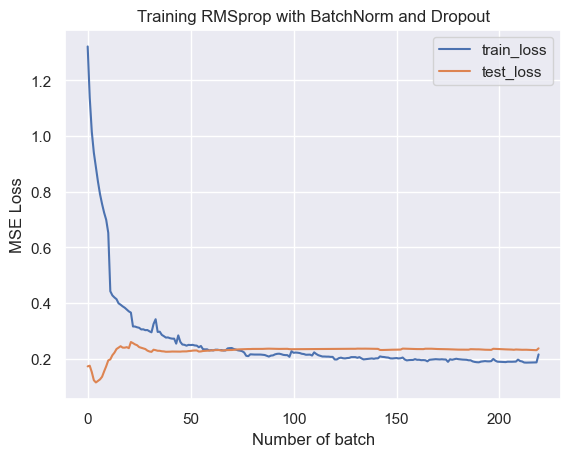

In [323]:
plt.plot(train_history_2['train_loss'], label='train_loss')
plt.plot(train_history_2['test_loss'], label='test_loss')
plt.title('Training RMSprop with BatchNorm and Dropout')
plt.xlabel('Number of batch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### 4) Train and test a model with Adam optimizer, BatchNorm, and Dropout layers.

In [ ]:
hidden_layer_dim = 16
model = LinearBatchNormDropoutModel(6, hidden_layer_dim)
model.train()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

num_epochs = 20
train_history_3 = {'train_loss': [], 'test_loss': []}
for epoch in range(num_epochs):  
    current_loss = 0.0
    for i, data in enumerate(df_train_loader):
        inputs, labels = data[0].float(), data[1].float()

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss

        model.eval()
        current_loss_test = 0.0
        for data in df_test_loader:
            test_inputs, test_labels = \
                data[0].float(), data[1].float()

            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs.flatten(), test_labels)

            current_loss_test += test_loss
        model.train()

        if i % 10 == 0:
            print(f'[Epoch {epoch + 1}, batch {i}] ' \
                  f'loss: {current_loss / (i + 1):.4f}; ' \
                  f'loss_test: {current_loss_test / 10:.4f}.')

        train_history_3['train_loss'].append(current_loss.item() / (i + 1))
        train_history_3['test_loss'].append(current_loss_test.item() / 10)

print('Training is finished!')

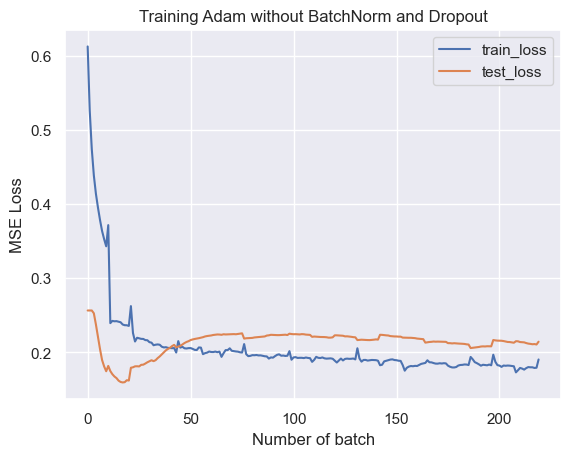

In [325]:
plt.plot(train_history_3['train_loss'], label='train_loss')
plt.plot(train_history_3['test_loss'], label='test_loss')
plt.title('Training Adam without BatchNorm and Dropout')
plt.xlabel('Number of batch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Conclusions

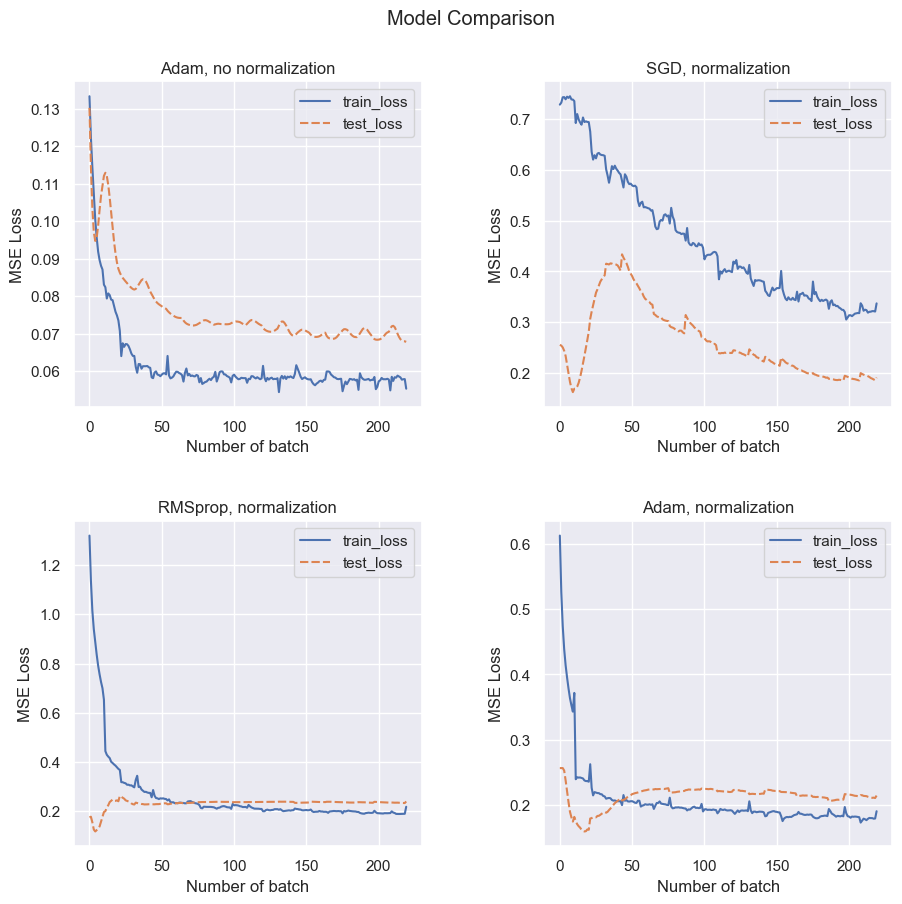

In [327]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))
fig.tight_layout()
fig.suptitle('Model Comparison')
plt.subplots_adjust(wspace=0.35, hspace=0.35, top=0.9)

sns.lineplot(data=train_history, ax=axes[0, 0]).set(title='Adam, no normalization', xlabel='Number of batch', ylabel='MSE Loss')
sns.lineplot(data=train_history_1, ax=axes[0, 1]).set(title='SGD, normalization', xlabel='Number of batch', ylabel='MSE Loss')
sns.lineplot(data=train_history_2, ax=axes[1, 0]).set(title='RMSprop, normalization', xlabel='Number of batch', ylabel='MSE Loss')
sns.lineplot(data=train_history_3, ax=axes[1, 1]).set(title='Adam, normalization', xlabel='Number of batch', ylabel='MSE Loss')

plt.show()

From the graph above I can conclude:
- The SGD is the slowest algorithm among all (such an obvious conclusion, I know :D).
- Dropout layers help to prevent the overfitting. On the graphs, the best scores of the models with normalization layers are worse in the end, but I assume if we would have had a validation data set, models with Dropout and Batch Norms layers had shown us better results.
- All the models seem to be complicated for this particular task, because their best scores were achieved during first 2-5 epochs of training and then they started to overfit. So, a model with less neurons will probably show better results.
  
For the further development, I could do some cross-validation estimations and tune the model. However, it's beyond this homework's scope :)